### Explore how to stablize the video

In [1]:
%run StyleTransfer.py
import cv2
video_path = "videoplayback.webm"
style_path = "blue-and-red-abstract-painting-1799912.jpg"

In [2]:
cap = cv2.VideoCapture(video_path)
for _ in range(500):
    cap.read()

In [3]:
frames20 = []
for _ in range(20):
    _, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames20.append(frame)

In [4]:
cap.release()

### Idea1: Inherit Grads

In [5]:
%run StyleTransfer.py

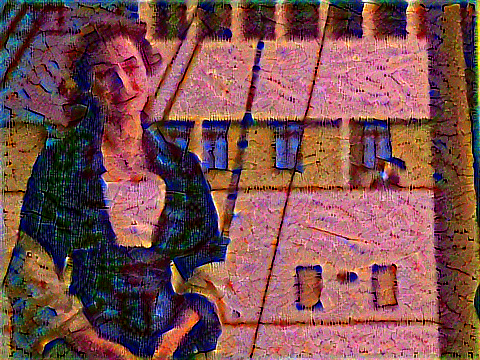

Train Step: 20
Total Time: 1.8


In [6]:
converted_frames20 = []
model = None
grads = None
for i in range(20):
    frame = frames20[i]
    tf.keras.backend.clear_session()
    if model is None:
        model = StyleTransfer(frame, style_path, style_layers=["block1_conv1", "block3_conv1", "block5_conv1"], video=True)
    else:
        model.update_content(frame, video=True)
    if grads is None:
        opt = tf.optimizers.Adam(learning_rate=0.1, beta_1=0.8, epsilon=1e-1)
        grads = model.transfer(opt, epochs=1, step_per_epoch=20, style_weight=1e6, content_weight=1e2, denoise_weight=400, return_grad=True)
    else:
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.8, epsilon=1e-1)
        for grad in grads:
            opt.apply_gradients([(grad, model.img)])
            model.img.assign(tf.clip_by_value(model.img, clip_value_min=0.0, clip_value_max=1.0))
        grads = model.transfer(opt, epochs=1, step_per_epoch=20, style_weight=1e6, content_weight=1e2, denoise_weight=400, return_grad=True)
    new_frame = model.get_frame(model.img)
    converted_frames20.append(new_frame)

In [7]:
def show_images(images):
    for image in images:
        plt.figure(figsize=(10, 6))
        plt.axis("off")
        plt.imshow(image)
        plt.show()
        clear_output(wait=True)

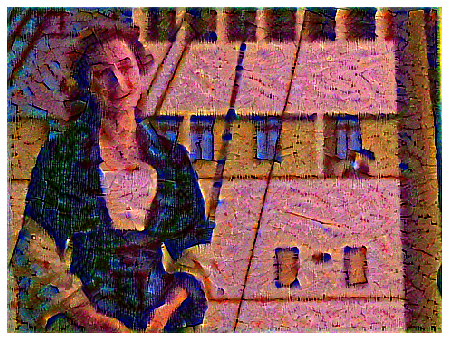

In [8]:
show_images(converted_frames20)

### Idea2: Loss for previous frame ?

In [9]:
%run StyleTransfer.py

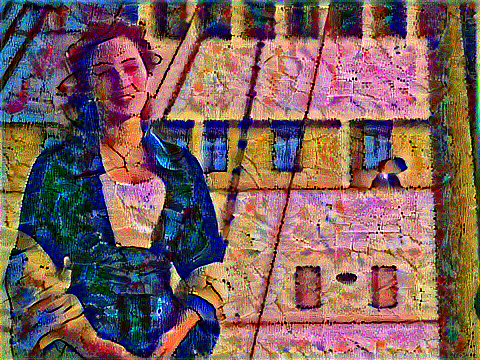

Train Step: 20
Total Time: 1.9


In [10]:
converted_frames20 = []
model = None
grads = None
previous_img = None
for i in range(20):
    frame = frames20[i]
    tf.keras.backend.clear_session()
    if model is None:
        model = StyleTransfer(frame, style_path, style_layers=["block1_conv1", "block3_conv1", "block5_conv1"], video=True)
    else:
        model.update_content(frame, video=True)
    if previous_img is None:
        opt = tf.optimizers.Adam(learning_rate=0.08, beta_1=0.8, epsilon=1e-1)
        model.transfer(opt, epochs=1, step_per_epoch=100, style_weight=1e6, content_weight=1e2, denoise_weight=1e2, previous_img=previous_img, previous_weight=1e4)
    else:
        opt = tf.optimizers.Adam(learning_rate=0.1, beta_1=0.8, epsilon=1e-1)
        model.transfer(opt, epochs=1, step_per_epoch=20, style_weight=1e2, content_weight=1e4, denoise_weight=1e4, previous_img=previous_img, previous_weight=1e4)
    previous_img = model.img
    new_frame = model.get_frame(model.img)
    converted_frames20.append(new_frame)

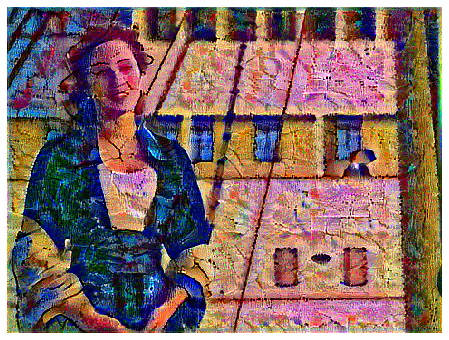

In [11]:
show_images(converted_frames20)

### Idea3: Add Noise  

Idea comes from this [blog](https://medium.com/element-ai-research-lab/stabilizing-neural-style-transfer-for-video-62675e203e42)

In [12]:
%run StyleTransfer.py

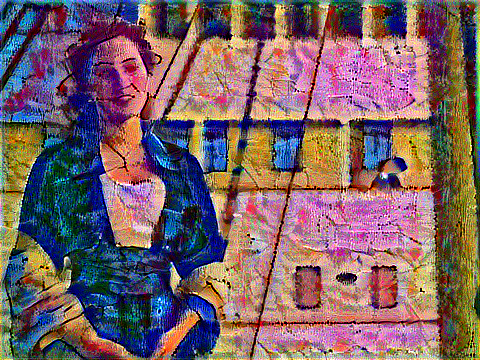

Train Step: 20
Total Time: 3.5


In [15]:
converted_frames20 = []
model = None
for i in range(20):
    frame = frames20[i]
    tf.keras.backend.clear_session()
    if model is None:
        model = StyleTransfer(frame, style_path, style_layers=["block1_conv1", "block3_conv1", "block5_conv1"], video=True)
    else:
        model.update_content(frame, video=True)
    opt = tf.optimizers.Adam(learning_rate=0.12, beta_1=0.8, epsilon=1e-1)
    model.transfer(opt, epochs=1, step_per_epoch=20, style_weight=1e4, content_weight=1e1, denoise_weight=1e2, noise_range=50, noise_count=1e2, noise_weight=1e6)
    new_frame = model.get_frame(model.img)
    converted_frames20.append(new_frame)

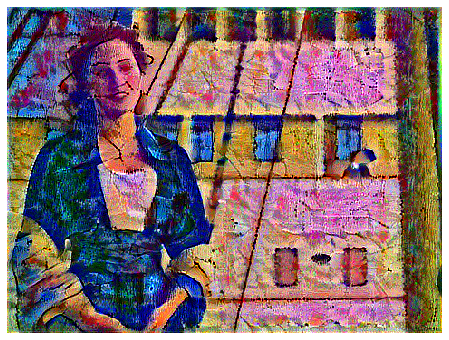

In [16]:
show_images(converted_frames20)